# Завантаження та попередня обробка даних

In [1]:
# Підключення необхідних бібліотек
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from numpy.polynomial import Polynomial
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, MiniBatchKMeans, BisectingKMeans

In [2]:
# # Завантаження даних з CSV-файлу
data = pd.read_csv('temperature_data_1day.csv')
# data = pd.read_csv('temperature_data_3days.csv')
# data = pd.read_csv('temperature_data_5days.csv')

In [3]:
# Виведення перших кількох рядків даних
print("Початкові дані:")
print(data.head())

Початкові дані:
             Timestamp  Temperature
0  2024-11-04 07:00:03         6.94
1  2024-11-04 07:00:05         6.94
2  2024-11-04 07:00:06         6.94
3  2024-11-04 07:00:08         6.94
4  2024-11-04 07:00:10         6.94


In [4]:
# Конвертація стовпця Timestamp в формат DateTime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [5]:
# Визначаємо мінімальну дату, від якої будемо рахувати секунди
min_date = data['Timestamp'].min().normalize()

In [6]:
# Обчислення секунд з початку мінімальної дати
data['Seconds'] = (data['Timestamp'] - min_date).dt.total_seconds()

In [7]:
# Підготовка даних для кластеризації
X = data[['Seconds', 'Temperature']]
print(X.head())

   Seconds  Temperature
0  25203.0         6.94
1  25205.0         6.94
2  25206.0         6.94
3  25208.0         6.94
4  25210.0         6.94


In [9]:
# Параметри
clusters_range = range(2, 101) # кількість кластерів, які будуть аналізуватися

# Кластеризація

In [10]:
# Функція для кластеризації даних в залежності від методу та кількості кластерів
def cluster_data(method_of_clusterring, num_clusters):
    # Кластеризація даних
    if method_of_clusterring == 'kmeans':
        model = KMeans(n_clusters=num_clusters, n_init=10, max_iter=300, tol=1e-4, random_state=0)
    elif method_of_clusterring == 'minibatch_kmeans':
        model = MiniBatchKMeans(n_clusters=num_clusters, n_init=10, max_iter=300, tol=1e-4, random_state=0)
    elif method_of_clusterring == 'bisecting_kmeans':
        model = BisectingKMeans(n_clusters=num_clusters, max_iter=300, tol=1e-4)
    elif method_of_clusterring == 'gmm':
        model = GaussianMixture(n_components=num_clusters, max_iter=300, tol=1e-4, random_state=0)
    else:
        raise ValueError("Невідомий метод кластеризації")

    labels = model.fit_predict(X)
    
    if method_of_clusterring == 'gmm':
        centers = model.means_
    else:
        centers = model.cluster_centers_
        
    return labels, centers

In [11]:
def calculate_all_clusterings(method_of_clustering, clusters_range):
    cluster_results = {}
    print(f"Обчислення результатів кластеризації для методу {method_of_clustering} для кількості кластерів [{clusters_range[0]}, {clusters_range[-1]}] ...")
    start_time = time.time()
    for num_clusters in clusters_range:
        labels, centers = cluster_data(method_of_clustering, num_clusters)
        cluster_results[num_clusters] = (labels, centers)
    
    # Загальний час виконання
    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes = int(elapsed_time // 60)
    seconds = int(elapsed_time % 60)

    print(f"Результати кластеризації для методу {method_of_clustering} обчислено за {minutes} хвилин {seconds} секунд")
    print("-"*20)
    return cluster_results

In [12]:
print("Результати кластеризації:")
print("="*20)
clusterings_data = {
    'kmeans': calculate_all_clusterings('kmeans', clusters_range),
    'minibatch_kmeans': calculate_all_clusterings('minibatch_kmeans', clusters_range),
    'bisecting_kmeans': calculate_all_clusterings('bisecting_kmeans', clusters_range),
    'gmm': calculate_all_clusterings('gmm', clusters_range)
}

Результати кластеризації:
Обчислення результатів кластеризації для методу kmeans для кількості кластерів [2, 10] ...
Результати кластеризації для методу kmeans обчислено за 0 хвилин 10 секунд
--------------------
Обчислення результатів кластеризації для методу minibatch_kmeans для кількості кластерів [2, 10] ...
Результати кластеризації для методу minibatch_kmeans обчислено за 0 хвилин 10 секунд
--------------------
Обчислення результатів кластеризації для методу bisecting_kmeans для кількості кластерів [2, 10] ...
Результати кластеризації для методу bisecting_kmeans обчислено за 0 хвилин 4 секунд
--------------------
Обчислення результатів кластеризації для методу gmm для кількості кластерів [2, 10] ...
Результати кластеризації для методу gmm обчислено за 0 хвилин 15 секунд
--------------------


In [14]:
# Функція для візуалізації результатів кластеризації з використанням готових даних
def plot_cluster_results(num_clusters):
    methods = ['kmeans', 'minibatch_kmeans', 'bisecting_kmeans', 'gmm']
    
    plt.figure(figsize=(20, 12))
    
    for i, method in enumerate(methods):
        # Отримуємо збережені labels і centers з словника clusterings_data для конкретного методу та кількості кластерів
        labels, centers = clusterings_data[method][num_clusters]
        
        plt.subplot(2, 2, i + 1)
        plt.scatter(X['Seconds'], X['Temperature'], c=labels, cmap='viridis', label='Дані')
        
        # Виведення центрів кластерів
        sorted_centers = centers[np.argsort(centers[:, 0])]
        plt.scatter(sorted_centers[:, 0], sorted_centers[:, 1], c='red', s=100, marker='.', label='Центри кластерів')
        
        plt.xlabel('Час (в секундах)')
        plt.ylabel('Температура')
        plt.title(f'Результати кластеризації за допомогою {method} для {num_clusters} кластерів')
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.suptitle('Результати кластеризації для різних методів', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

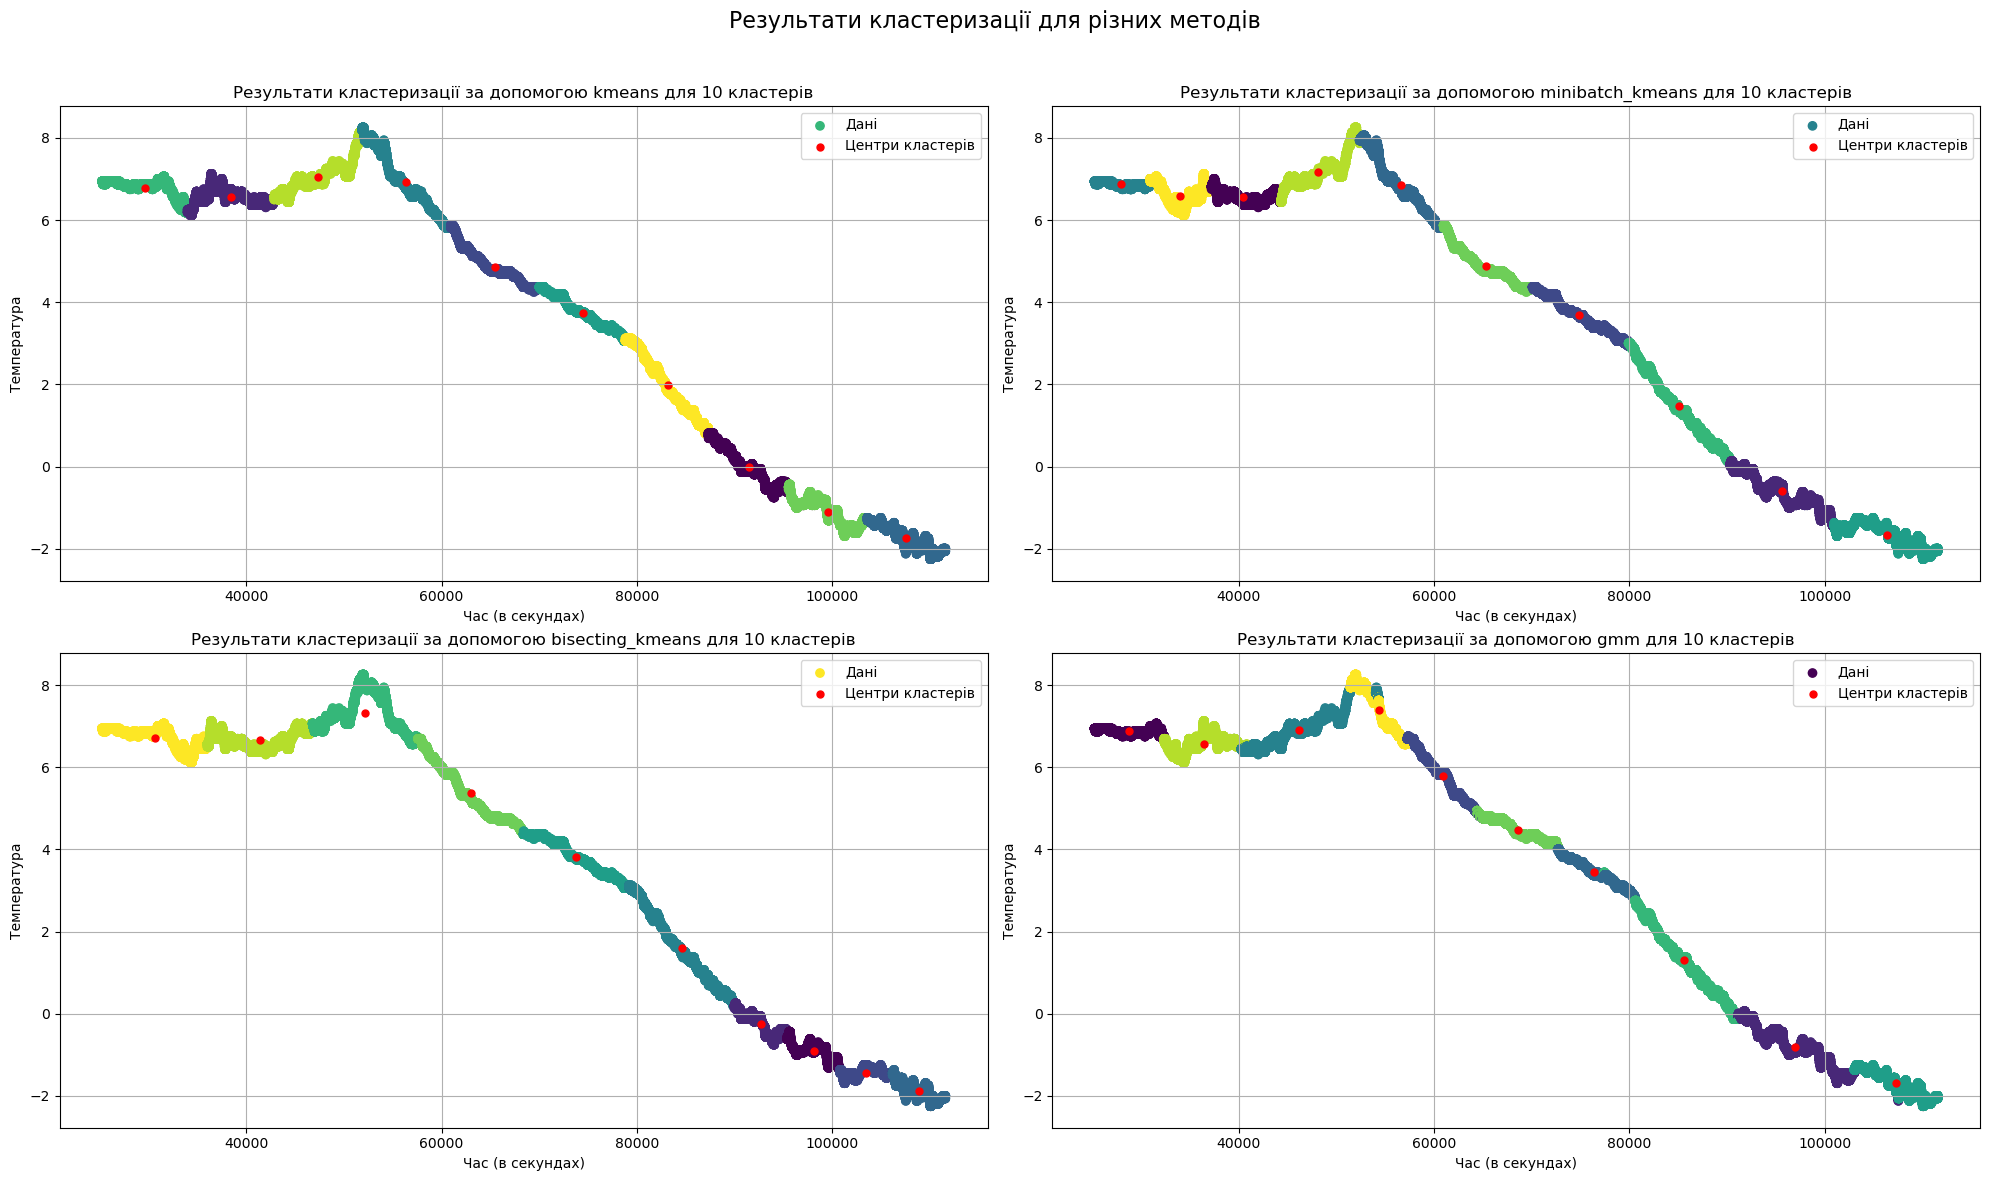

In [16]:
# # Візуалізація результатів кластеризації для 30 кластерів
plot_cluster_results(30)

# Попередній аналіз методів кластеризації

## Інтерполяція та апроксимація

In [17]:
def get_approximated_temperatures(x, y, method_type, poly_degree=20):
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    
    if method_type == 'approximation':
        # Апроксимація
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=np.RankWarning)
            coeffs = np.polyfit(x_sorted, y_sorted, poly_degree)
        return np.polyval(coeffs, X['Seconds'])
    elif method_type == 'interpolation':
        # Інтерполяція
        return np.interp(X['Seconds'], x_sorted, y_sorted)
    else:
        raise ValueError("Невідомий тип методу: використовуйте 'approximation' або 'interpolation'.")

In [18]:
def calculate_all_approximations(method_type, clusters_range, method_of_clustering):
    approximations = {}
    if method_type == 'interpolation':
        text = 'інтерпольованих'
    else:
        text = 'апроксимованих'
    print(f"Обчислення {text} даних для методу {method_of_clustering}...")
    for num_clusters in clusters_range:
        labels, centers = clusterings_data[method_of_clustering][num_clusters] 
        # Отримуємо унікальні значення температур для апроксимації/інтерполяції
        x = centers[:, 0]
        y = centers[:, 1] 

        # Обчислюємо апроксимацію або інтерполяцію
        approximated_values = get_approximated_temperatures(x, y, method_type)
        approximations[num_clusters] = approximated_values

    print(f"Дані для методу {method_of_clustering} обчислено")
    print("-"*20)

    return approximations

In [19]:
print("Інтерпольовані дані:")
print("="*20)
interpolated_clustering_data = {
    'kmeans': calculate_all_approximations('interpolation', clusters_range, 'kmeans'),
    'minibatch_kmeans': calculate_all_approximations('interpolation', clusters_range, 'minibatch_kmeans'),
    'bisecting_kmeans': calculate_all_approximations('interpolation', clusters_range, 'bisecting_kmeans'),
    'gmm': calculate_all_approximations('interpolation', clusters_range, 'gmm')
}

Інтерпольовані дані:
Обчислення інтерпольованих даних для методу kmeans...
Дані для методу kmeans обчислено
--------------------
Обчислення інтерпольованих даних для методу minibatch_kmeans...
Дані для методу minibatch_kmeans обчислено
--------------------
Обчислення інтерпольованих даних для методу bisecting_kmeans...
Дані для методу bisecting_kmeans обчислено
--------------------
Обчислення інтерпольованих даних для методу gmm...
Дані для методу gmm обчислено
--------------------


In [20]:
print("Апроксимовані дані:")
print("="*20)
approximated_clustering_data = {
    'kmeans': calculate_all_approximations('approximation', clusters_range, 'kmeans'),
    'minibatch_kmeans': calculate_all_approximations('approximation', clusters_range, 'minibatch_kmeans'),
    'bisecting_kmeans': calculate_all_approximations('approximation', clusters_range, 'bisecting_kmeans'),
    'gmm': calculate_all_approximations('approximation', clusters_range, 'gmm')
}

Апроксимовані дані:
Обчислення апроксимованих даних для методу kmeans...
Дані для методу kmeans обчислено
--------------------
Обчислення апроксимованих даних для методу minibatch_kmeans...
Дані для методу minibatch_kmeans обчислено
--------------------
Обчислення апроксимованих даних для методу bisecting_kmeans...
Дані для методу bisecting_kmeans обчислено
--------------------
Обчислення апроксимованих даних для методу gmm...
Дані для методу gmm обчислено
--------------------


In [21]:
def plot_all_approximations(num_clusters, method_type):
    methods = ['kmeans', 'minibatch_kmeans', 'bisecting_kmeans', 'gmm']
    
    plt.figure(figsize=(20, 12))
    
    if method_type == 'interpolation':
        data = interpolated_clustering_data
        title_text = "Інтерполяція"
    elif method_type == 'approximation':
        data = approximated_clustering_data
        title_text = "Апроксимація"
    else:
        raise ValueError("Невідомий тип методу: використовуйте 'interpolation' або 'approximation'.")

    for i, method in enumerate(methods):
        # Отримуємо інтерпольовані або апроксимовані значення для конкретного методу і кількості кластерів
        approximated_values = data[method][num_clusters]
        
        # Сортуємо дані для графіку
        sorted_indices = np.argsort(X['Seconds'])
        x_sorted = X['Seconds'][sorted_indices]
        y_sorted = X['Temperature'][sorted_indices]
        approximated_sorted = np.array(approximated_values)[sorted_indices]
        
        # Отримуємо центри кластерів та сортуємо їх
        _, centers = clusterings_data[method][num_clusters]
        sorted_centers = centers[np.argsort(centers[:, 0])]

        plt.subplot(2, 2, i + 1)
        plt.scatter(x_sorted, y_sorted, color='grey', alpha=0.5, label='Початкові дані')
        plt.plot(x_sorted, approximated_sorted, label=f'{title_text} центрів', color='orange')
        
        # Відображення центрів кластерів як червоних точок
        plt.scatter(sorted_centers[:, 0], sorted_centers[:, 1], color='red', s=50, marker='o', label='Центри кластерів')
        
        plt.xlabel('Час (в секундах)')
        plt.ylabel('Температура')
        plt.title(f'{title_text} центрів кластерів для методу {method} ({num_clusters} кластерів)')
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.suptitle(f'{title_text} центрів кластерів для різних методів', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

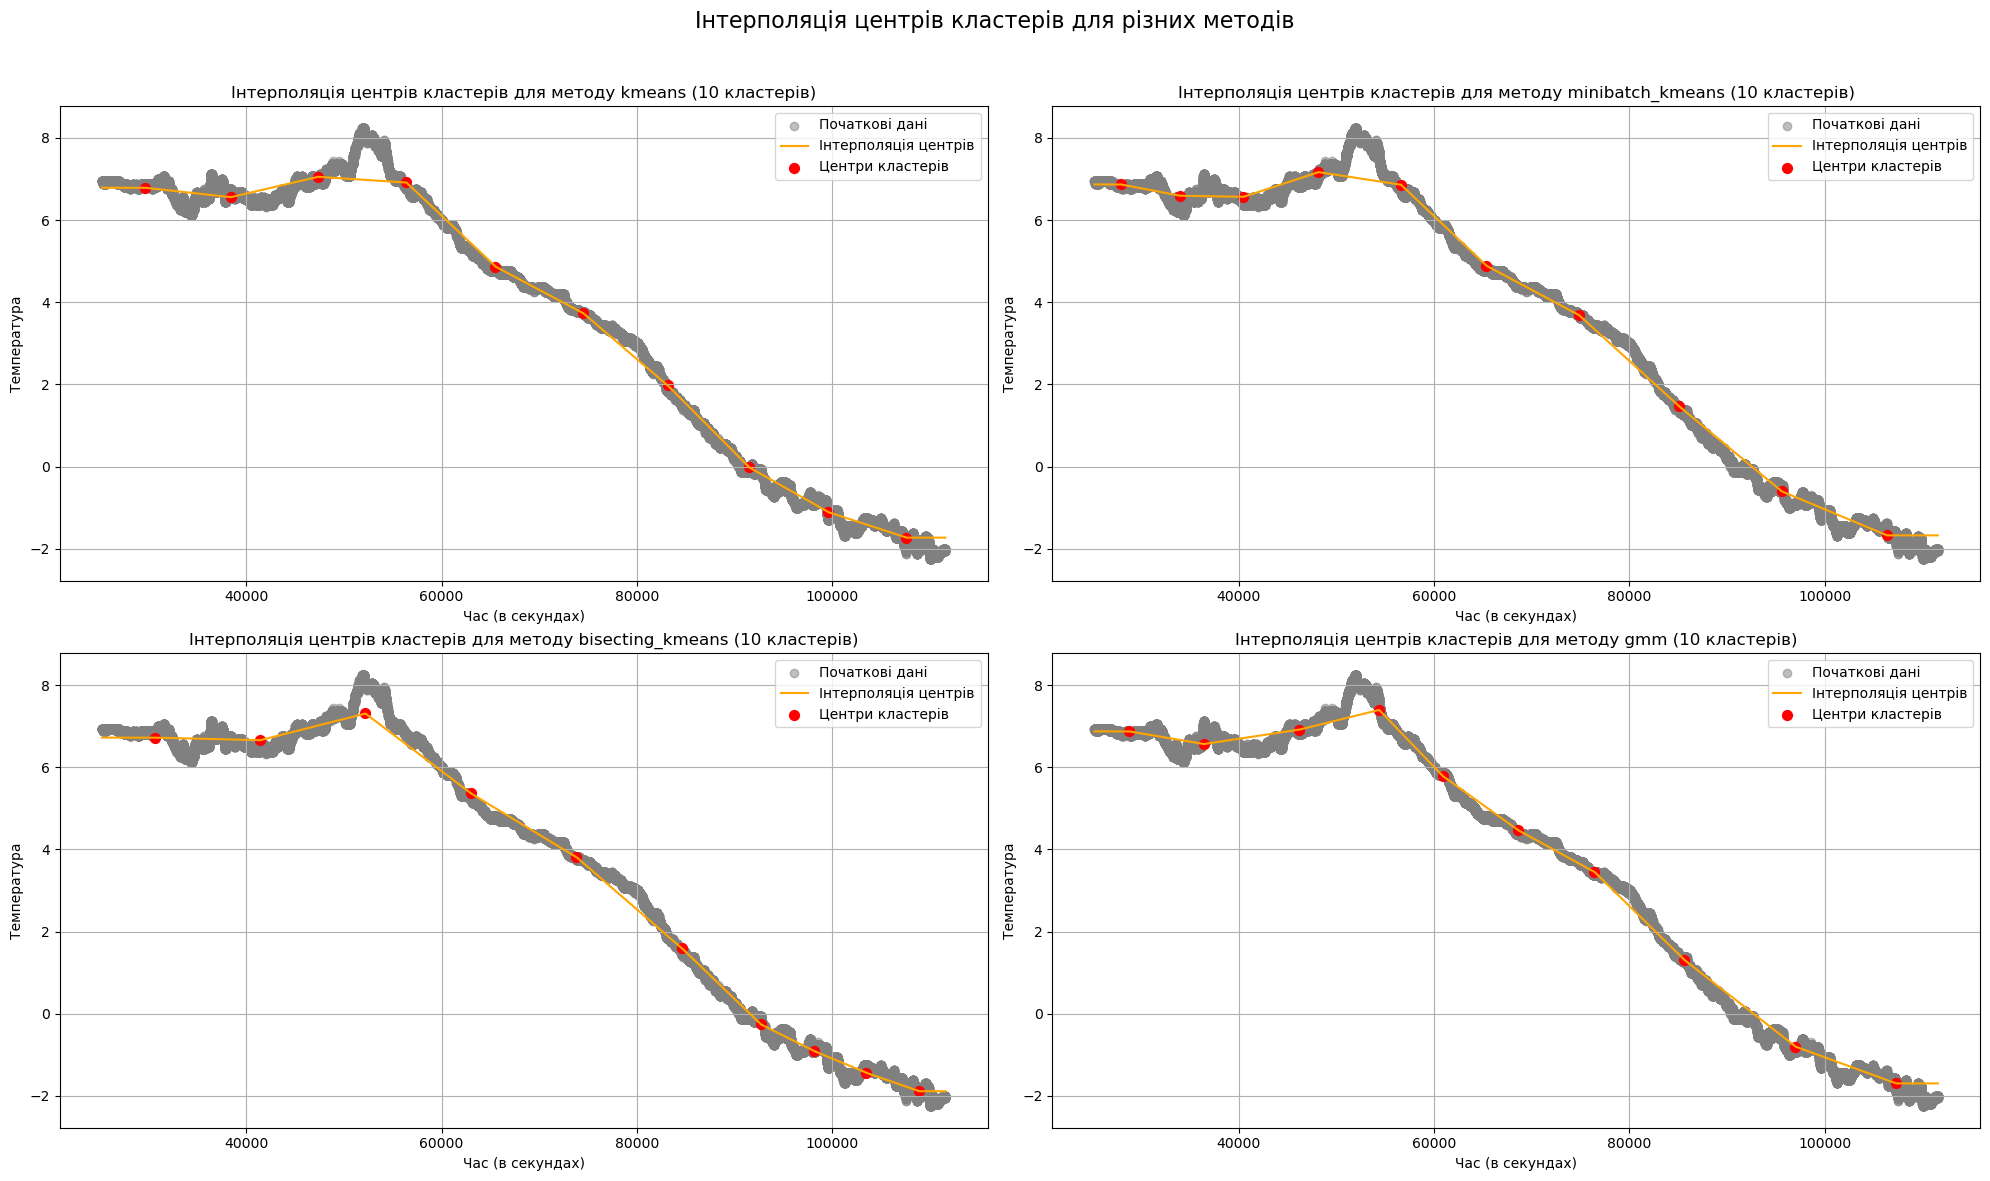

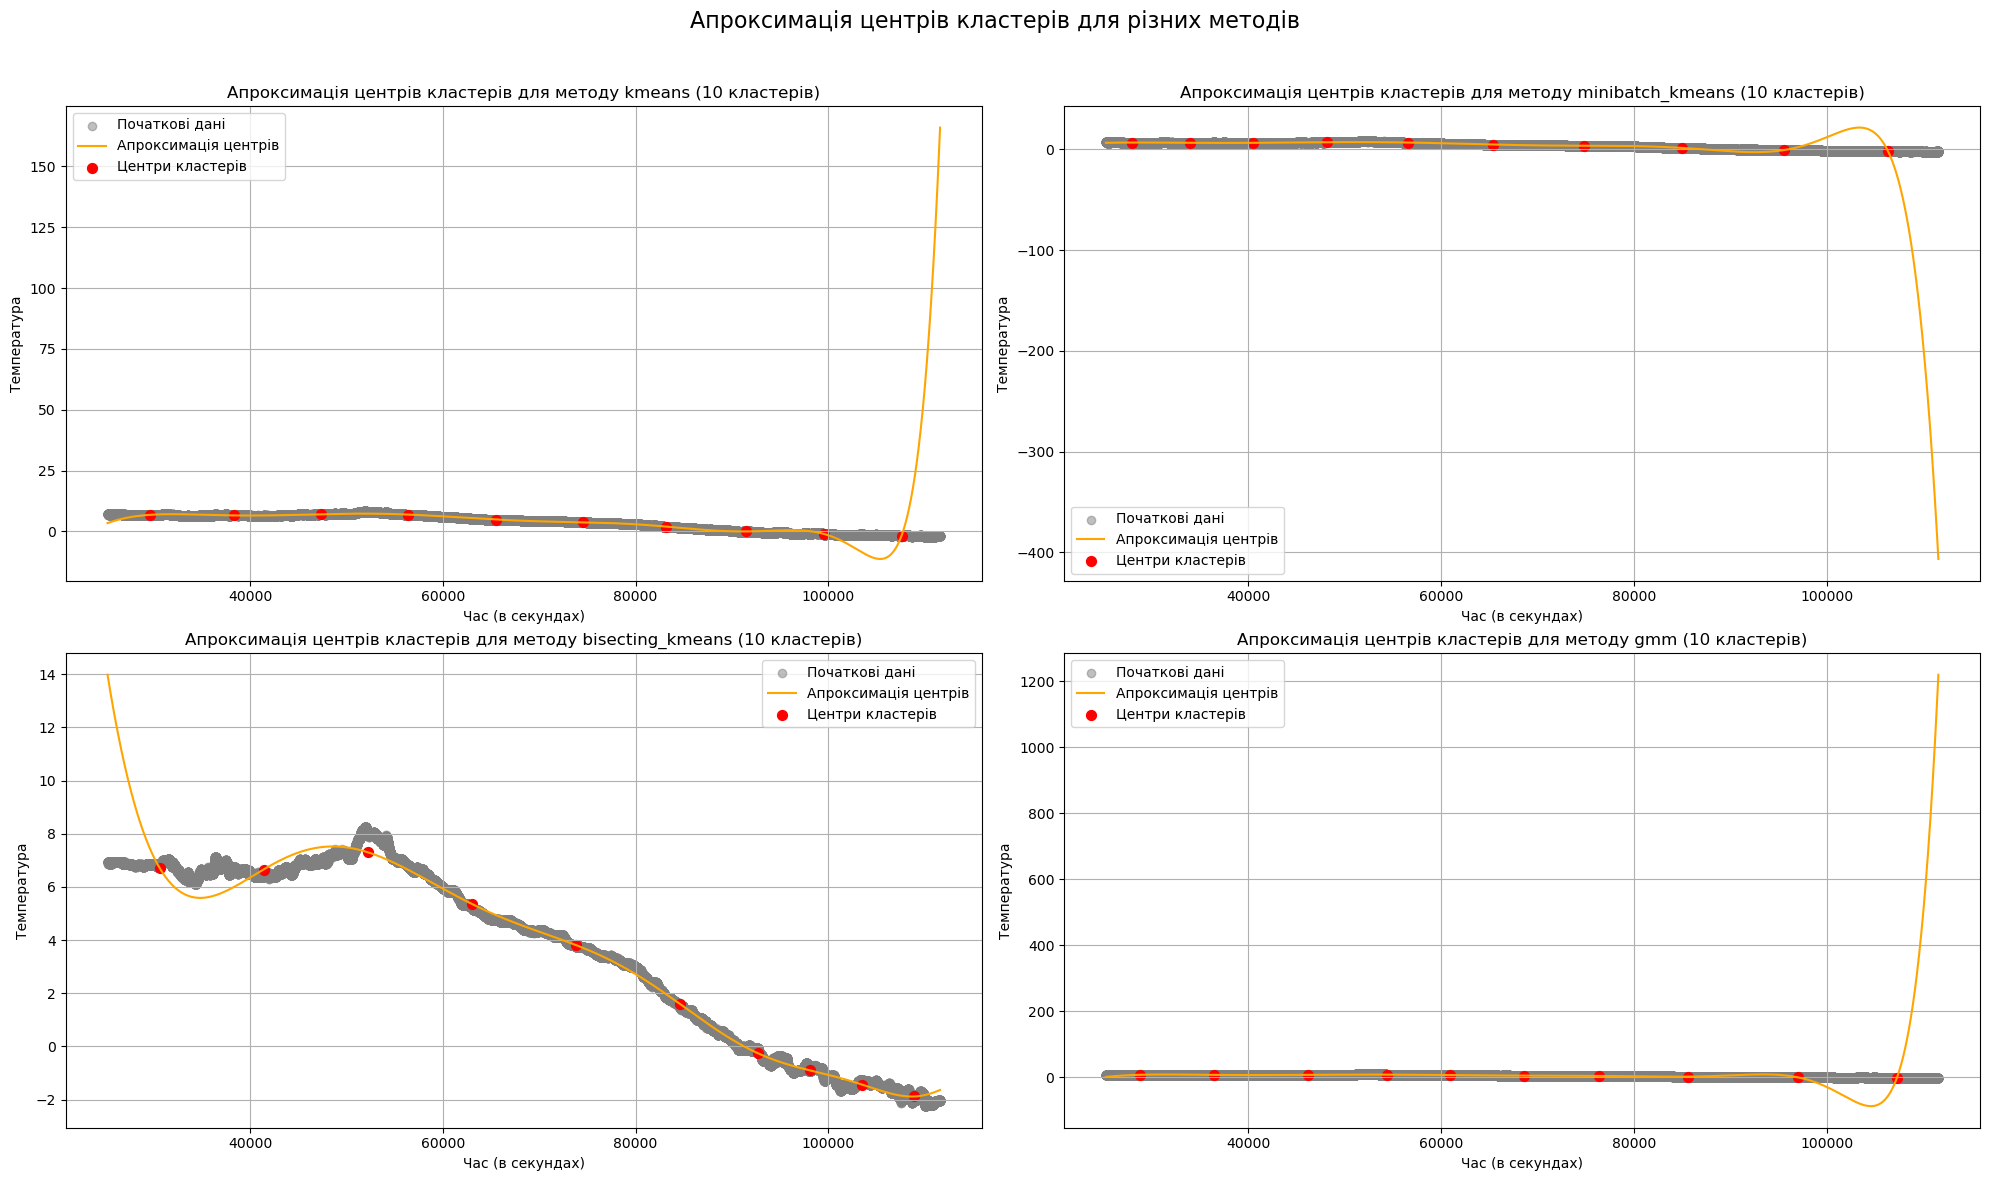

In [22]:
# Виклик функції для відображення інтерпольованих або апроксимованих даних
plot_all_approximations(50, 'interpolation')
plot_all_approximations(50, 'approximation') # 'interpolation' або 'approximation'

## Обчислення дисперсії

In [23]:
# Функція для обчислення дисперсії
def calc_dispersion(interpolated_or_approximated_data):
    n = len(X)
    dispersion = np.sqrt(np.sum((X['Temperature'] - interpolated_or_approximated_data) ** 2) / n)
    return dispersion

In [24]:
def get_dispersion_value_for_single_cluster(method_of_clustering, num_clusters, method_type):
    # Отримуємо апроксимовані або інтерпольовані температури
    if method_type == 'interpolation':
        approximated_temperatures = interpolated_clustering_data[method_of_clustering][num_clusters]
    else:  # 'approximation'
        approximated_temperatures = approximated_clustering_data[method_of_clustering][num_clusters]

    # Обчислення дисперсії
    dispersion = calc_dispersion(approximated_temperatures)
    return dispersion

In [25]:
# Функція для обчислення дисперсії для різної кількості кластерів та методів
def get_dispersion_values(method_of_clustering, clusters_range, method_type):
    dispersion_values = []
    print(f"Обчислення дисперсії для методу {method_of_clustering}...")
    
    for num_clusters in clusters_range:
        # Отримуємо апроксимовані або інтерпольовані температури
        if method_type == 'interpolation':
            approximated_temperatures = interpolated_clustering_data[method_of_clustering][num_clusters]
        else:  # 'approximation'
            approximated_temperatures = approximated_clustering_data[method_of_clustering][num_clusters]

        # Обчислення дисперсії
        dispersion = calc_dispersion(approximated_temperatures)
        dispersion_values.append(dispersion)

    print(f"Дисперсію для методу {method_of_clustering} обчислено")
    print("-" * 20)

    return dispersion_values

In [26]:
print("Значення дисперії для інтерполяції:")
print("="*20)
interpolated_dispersion_data = {
    'kmeans': get_dispersion_values('kmeans', clusters_range, 'interpolation'),
    'minibatch_kmeans': get_dispersion_values('minibatch_kmeans', clusters_range, 'interpolation'),
    'bisecting_kmeans': get_dispersion_values('bisecting_kmeans', clusters_range, 'interpolation'),
    'gmm': get_dispersion_values('gmm', clusters_range, 'interpolation'),
}

Значення дисперії для інтерполяції:
Обчислення дисперсії для методу kmeans...
Дисперсію для методу kmeans обчислено
--------------------
Обчислення дисперсії для методу minibatch_kmeans...
Дисперсію для методу minibatch_kmeans обчислено
--------------------
Обчислення дисперсії для методу bisecting_kmeans...
Дисперсію для методу bisecting_kmeans обчислено
--------------------
Обчислення дисперсії для методу gmm...
Дисперсію для методу gmm обчислено
--------------------


In [27]:
print("Значення дисперії для апроксимації:")
print("="*20)
approximated_dispersion_data = {
    'kmeans': get_dispersion_values('kmeans', clusters_range, 'approximation'),
    'minibatch_kmeans': get_dispersion_values('minibatch_kmeans', clusters_range, 'approximation'),
    'bisecting_kmeans': get_dispersion_values('bisecting_kmeans', clusters_range, 'approximation'),
    'gmm': get_dispersion_values('gmm', clusters_range, 'approximation'),
}

Значення дисперії для апроксимації:
Обчислення дисперсії для методу kmeans...
Дисперсію для методу kmeans обчислено
--------------------
Обчислення дисперсії для методу minibatch_kmeans...
Дисперсію для методу minibatch_kmeans обчислено
--------------------
Обчислення дисперсії для методу bisecting_kmeans...
Дисперсію для методу bisecting_kmeans обчислено
--------------------
Обчислення дисперсії для методу gmm...
Дисперсію для методу gmm обчислено
--------------------


In [32]:
# Функція для виведення графіків змін дисперсії для кожного методу
def plot_all_methods_dispersion(dispersion_data, clusters_range):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.ravel()

    for i, (method, dispersion_values) in enumerate(dispersion_data.items()):
        axs[i].plot(clusters_range, dispersion_values, marker='o')
        axs[i].set_title(f'Зміна дисперсії для методу {method}')
        axs[i].set_xlabel('Кількість кластерів')
        axs[i].set_ylabel('Дисперсія')
        axs[i].grid(True)
        axs[i].set_xticks(clusters_range[::4])

    plt.tight_layout()
    plt.show()


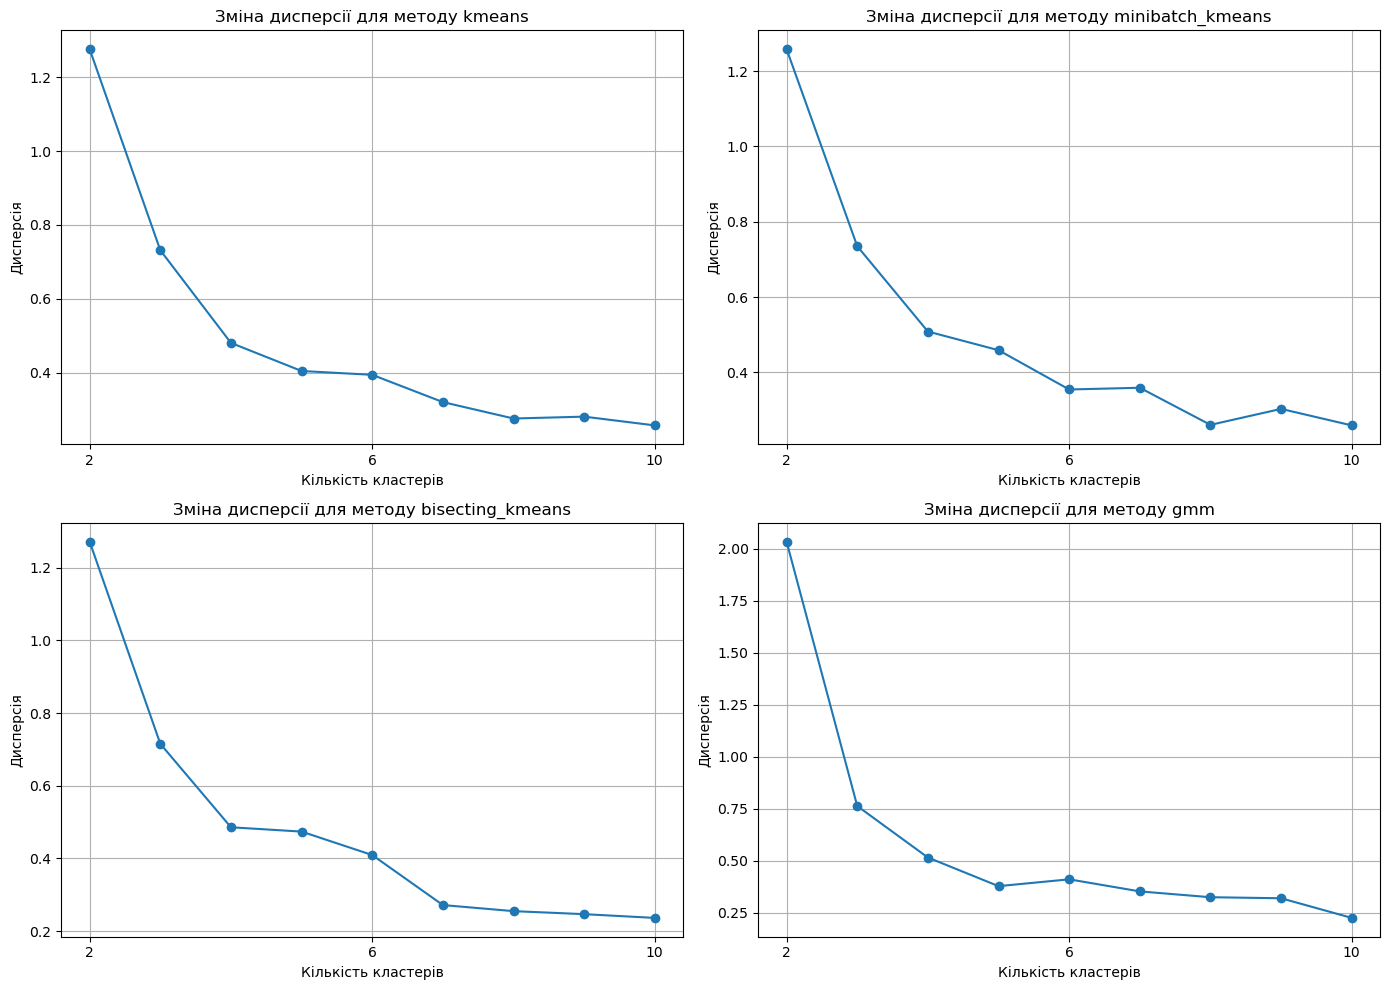

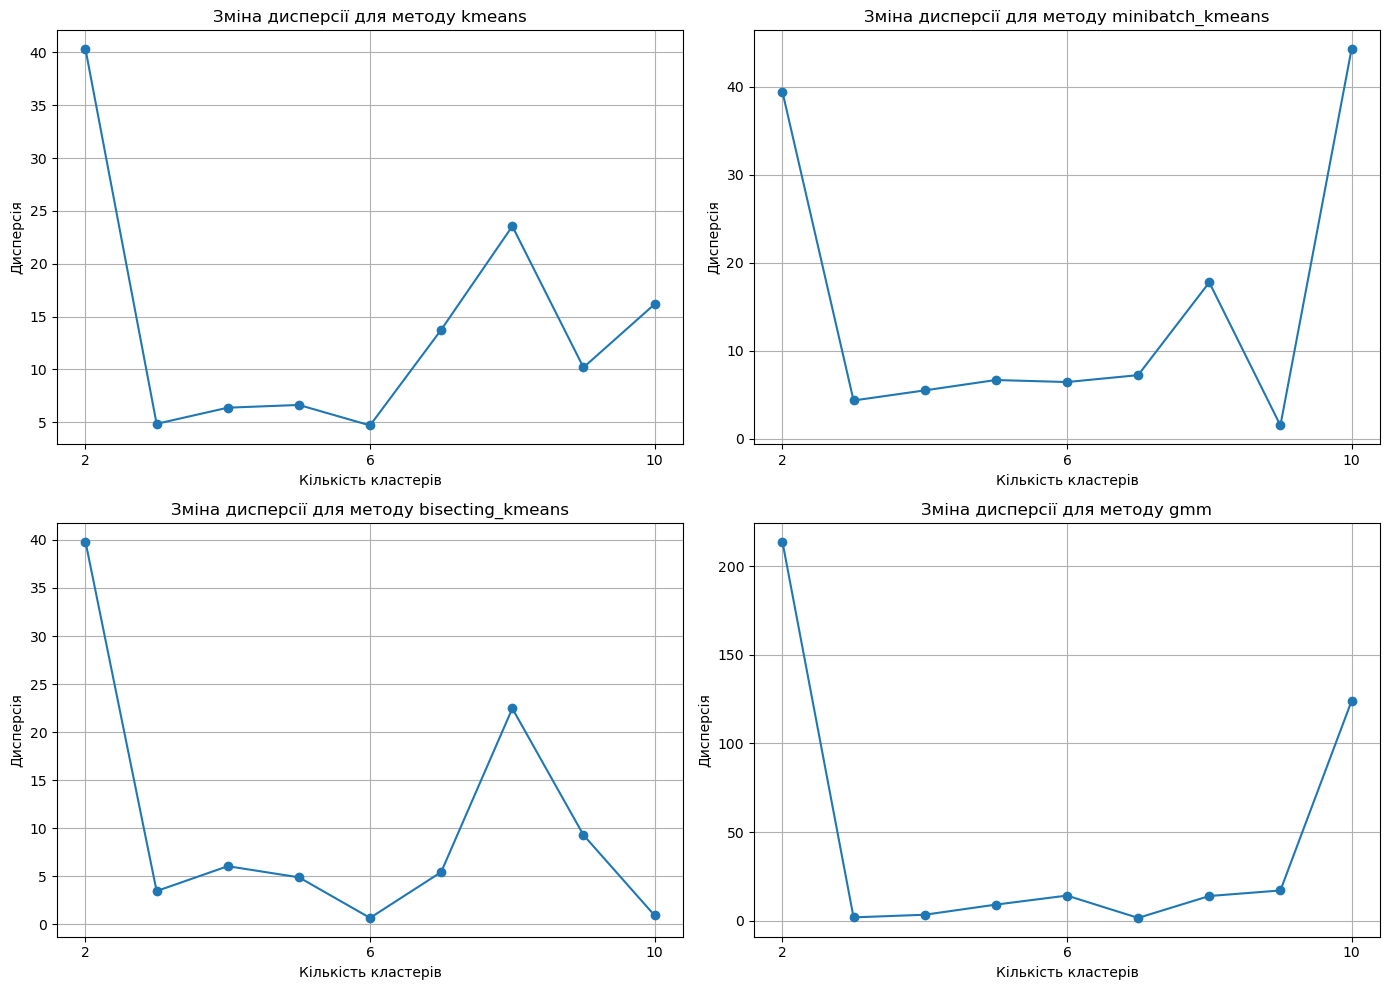

In [33]:
plot_all_methods_dispersion(interpolated_dispersion_data, clusters_range)
plot_all_methods_dispersion(approximated_dispersion_data, clusters_range)

## Гістограма порівняння значень дисперсії

In [34]:
# Функція отримання значення дисперсії для конкретного числа кластерів та методу кластеризації 
def compare_dispersion_for_clusters(num_clusters, method_type):
    dispersions = []
    method_names = []

    for method in ['kmeans', 'minibatch_kmeans', 'bisecting_kmeans', 'gmm']:
        if method_type == 'interpolation':
            dispersion = interpolated_dispersion_data[method][num_clusters]
        else:  # 'approximation'
            dispersion = approximated_dispersion_data[method][num_clusters]

        dispersions.append(dispersion)
        method_names.append(method)

    return method_names, dispersions

In [35]:
# Функція для побудови гістограми порівняння значень дисперсії
def plot_dispersion_histogram(num_clusters, method_type):
    method_names, dispersions = compare_dispersion_for_clusters(num_clusters, method_type)

    y_min = min(dispersions) * 0.9
    y_max = max(dispersions) * 1.1

    # Побудова гістограми
    plt.figure(figsize=(10, 6))
    plt.bar(method_names, dispersions)
    plt.xlabel('Метод кластеризації')
    plt.ylabel('Дисперсія')
    plt.title(f'Порівняння дисперсії для {num_clusters} кластерів між методами ({method_type.capitalize()})')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.ylim(y_min, y_max)
        
    plt.show()

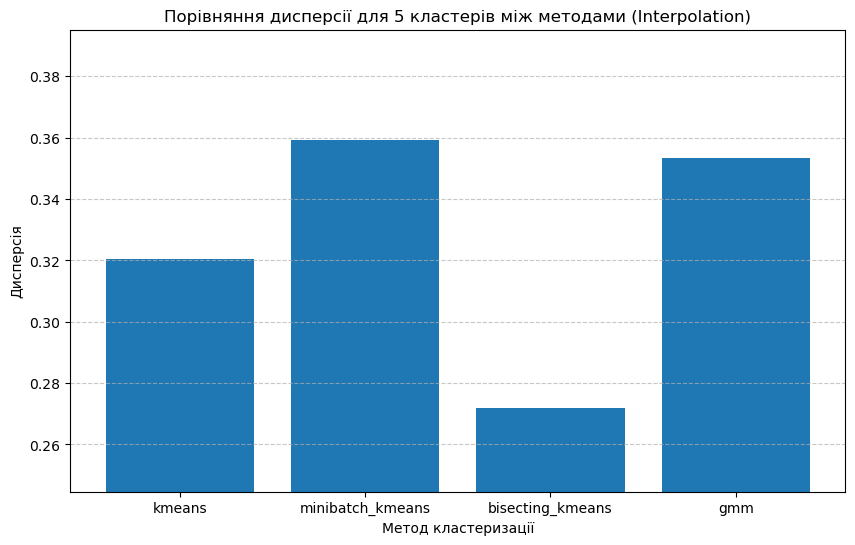

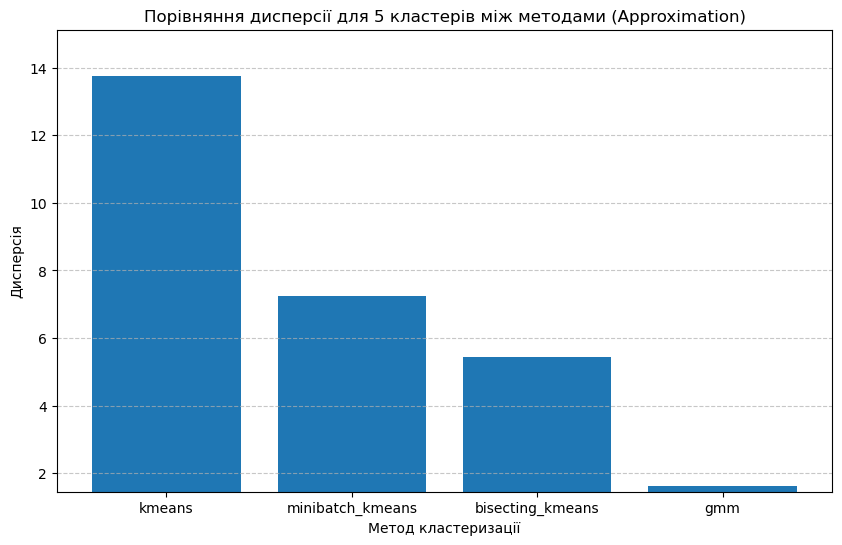

In [44]:
plot_dispersion_histogram(50, 'interpolation')
plot_dispersion_histogram(50, 'approximation')

In [45]:
def calculate_dispersion_differences(dispersion_values):
    differences = []
    for i in range(len(dispersion_values) - 1):
        differences.append(dispersion_values[i] - dispersion_values[i + 1])
    return differences

In [48]:
# Функція для візуалізації різниць дисперсії для всіх методів на одному графіку
def plot_all_methods_dispersion_differences(clusters_range, dispersion_data):
    plt.figure(figsize=(12, 8))

    for i, (method, dispersion_values) in enumerate(dispersion_data.items()):
        # Отримуємо різниці дисперсій для конкретного методу
        differences = calculate_dispersion_differences(dispersion_values)
        
        plt.subplot(2, 2, i + 1)  # Створюємо сітку 2x2 для графіків
        plt.plot(clusters_range[:-1], differences, marker='o', color='orange')  # Використовуємо clusters_range[:-1]
        plt.title(f'Різницевий графік ({method})')
        plt.xlabel('Кількість кластерів')
        plt.ylabel('Різниця дисперсії')
        plt.axhline(0, color='red', linestyle='--', linewidth=0.8)  # Горизонтальна лінія на рівні 0
        plt.grid()
        plt.xticks(clusters_range[::4])

    plt.tight_layout()  # Оптимізація розташування підграфіків
    plt.show()

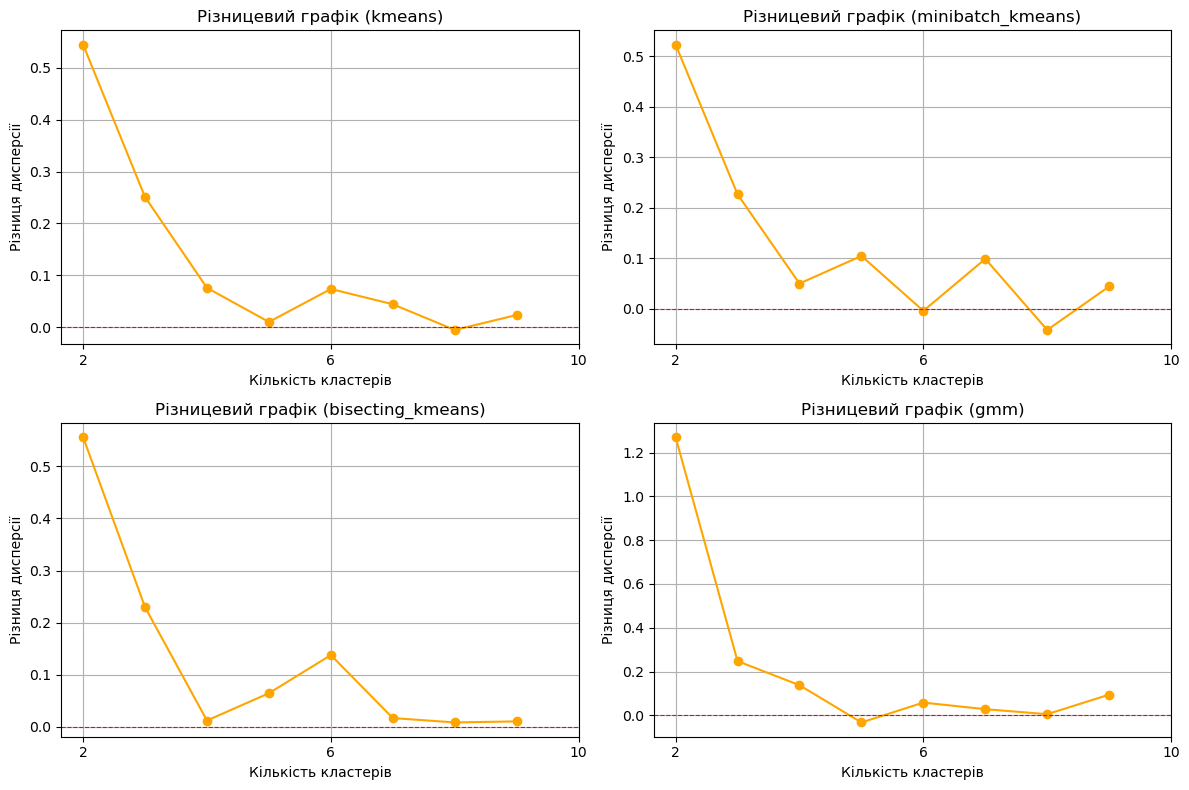

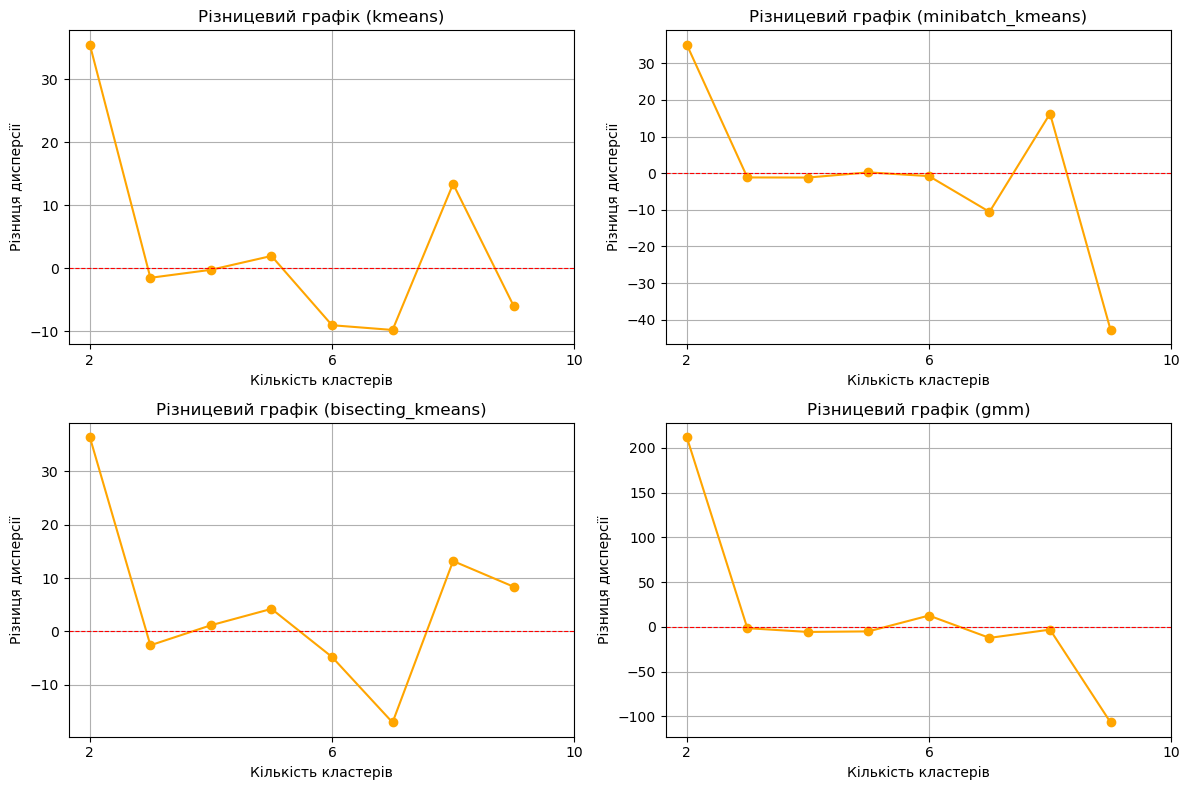

In [49]:
plot_all_methods_dispersion_differences(clusters_range, interpolated_dispersion_data)
plot_all_methods_dispersion_differences(clusters_range, approximated_dispersion_data)

# Знаходження оптимальних параметрів кластеризації для кожного методу

## Вибір оптимальної кількості кластерів

In [50]:
def find_optimal_clusters(dispersion_data, clusters_range, method, threshold=0.05):
    # Перевірка наявності методу в dispersion_data
    if method not in dispersion_data:
        raise ValueError(f"Метод '{method}' не знайдено в даних дисперсії.")

    # Отримуємо значення дисперсії для обраного методу
    dispersion_values = dispersion_data[method]
    
    # Виконуємо лінійну регресію для кластерів від 20 до кінця
    start_idx = 20 - 2  # Індекс початку з кластерів 20 (відповідний 18)
    x_regression = np.array(clusters_range[start_idx:])  # Кількість кластерів від 20 до кінця
    y_regression = np.array(dispersion_values[start_idx:])

    # Лінійна регресія
    slope, intercept, _, _, _ = linregress(x_regression, y_regression)
    
    # Обчислення лінії тренду для всього діапазону
    fitted_line = slope * np.array(clusters_range) + intercept

    print(f"Обчислення оптимальної кількості кластерів для методу {method}...")
    
    # Пошук оптимальної кількості кластерів за відхиленням менше за поріг
    for i in range(len(dispersion_values)):
        deviation = np.abs(dispersion_values[i] - fitted_line[i])
        if deviation < threshold:
            print(f"Оптимальна кількість кластерів для методу {method}: {clusters_range[i]}")
            print("-"*20)
            return clusters_range[i]  # Повертає оптимальну кількість кластерів

    return None  # Оптимальну кількість кластерів не знайдено в межах порогу

In [40]:
print("Знаходження оптимальної кількості кластерів:")
print("="*20)
optimal_clusters = {
    'kmeans': find_optimal_clusters(interpolated_dispersion_data, clusters_range, 'kmeans'),
    'minibatch_kmeans': find_optimal_clusters(interpolated_dispersion_data, clusters_range, 'minibatch_kmeans'),
    'bisecting_kmeans': find_optimal_clusters(interpolated_dispersion_data, clusters_range, 'bisecting_kmeans'),
    'gmm': find_optimal_clusters(interpolated_dispersion_data, clusters_range, 'gmm')
}

Знаходження оптимальної кількості кластерів:


ValueError: Inputs must not be empty.

In [ ]:
def plot_all_methods_dispersion_with_regression(dispersion_data, clusters_range, optimal_clusters):
    plt.figure(figsize=(14, 10))

    for i, method in enumerate(dispersion_data.keys()):
        # Отримуємо значення дисперсії для обраного методу
        dispersion_values = dispersion_data[method]

        # Лінійна регресія для кластерів від 20 до кінця
        start_idx = 20 - 2  # Індекс початку з кластерів 20 (відповідний 18)
        x = np.array(clusters_range[start_idx:])  # Кількість кластерів від 20 до кінця
        y = np.array(dispersion_values[start_idx:])

        # Лінійна регресія
        slope, intercept, _, _, _ = linregress(x, y)

        # Обчислення лінії тренду для всього діапазону кластерів
        fitted_line_full = slope * np.array(clusters_range) + intercept

        # Побудова графіку дисперсії і лінії регресії
        plt.subplot(2, 2, i + 1)  # Створюємо сітку 2x2 для графіків
        plt.plot(clusters_range, dispersion_values, marker='o', label='Дисперсія', color='blue')
        plt.plot(clusters_range, fitted_line_full, color='orange', linestyle='--', label='Лінійна регресія')

        # Виділення оптимальної кількості кластерів
        if optimal_clusters[method] is not None:
            optimal_index = optimal_clusters[method] - clusters_range[0]  # Скоригований індекс
            optimal_dispersion = dispersion_values[optimal_index]
            plt.scatter(optimal_clusters[method], optimal_dispersion, color='red', s=100, label='Оптимальна кількість кластерів')

        plt.title(f'Зміна дисперсії з лінійною регресією ({method})')
        plt.xlabel('Кількість кластерів')
        plt.ylabel('Дисперсія')
        plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)  # Горизонтальна лінія на y=0
        plt.grid()
        plt.xticks(clusters_range[::4])
        plt.legend()

    plt.tight_layout()  # Налаштування підгонки для графіків
    plt.show()


In [ ]:
# Виклик функції для відображення графіків
plot_all_methods_dispersion_with_regression(interpolated_dispersion_data, clusters_range, optimal_clusters)

## Вибір оптимального ступеня полінома

In [ ]:
def find_optimal_polynomial_degree(clusterings_data, num_clusters, method_of_clustering):
    # Отримуємо центри кластерів
    centers = clusterings_data[method_of_clustering][num_clusters][1]
    
    x = centers[:, 0]  # Перший стовпець центрів - це значення 'Seconds'
    y = centers[:, 1]  # Другий стовпець центрів - це значення 'Temperature'

    optimal_degree = None
    min_dispersion = float('inf')
    polynomial_degrees = list(range(1, 31))  # Ступені полінома від 1 до 30

    print(f"Обчислення оптимальної кількості поліномів для методу {method_of_clustering}...")

    # Ігноруємо попередження про переповнення
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)

        for poly_degree in polynomial_degrees:
            approximated_temperatures = get_approximated_temperatures(x, y, 'approximation', poly_degree=poly_degree)
            dispersion = calc_dispersion(approximated_temperatures)

            # Перевірка на мінімальне значення дисперсії
            if dispersion < min_dispersion:
                min_dispersion = dispersion
                optimal_degree = poly_degree  # Оновлюємо оптимальний поліном

    print(f"Оптимальна кількість поліномів знайдена: {optimal_degree}")
    print("-" * 20)
    return optimal_degree

In [ ]:
# Виклик функції для обчислення оптимальних поліномів
print("Знаходження оптимальної кількості поліномів:")
print("="*20)
optimal_polynomial_degrees = {
    'kmeans': find_optimal_polynomial_degree(clusterings_data, optimal_clusters['kmeans'], 'kmeans'),
    'minibatch_kmeans': find_optimal_polynomial_degree(clusterings_data, optimal_clusters['minibatch_kmeans'], 'minibatch_kmeans'),
    'bisecting_kmeans': find_optimal_polynomial_degree(clusterings_data, optimal_clusters['bisecting_kmeans'], 'bisecting_kmeans'),
    'gmm': find_optimal_polynomial_degree(clusterings_data, optimal_clusters['gmm'], 'gmm')
}

In [ ]:
def plot_polynomial_dispersion(optimal_polynomial_degrees, clusterings_data):
    # Створення фігури з 4 підграфіками
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()  # Перетворюємо 2D масив в 1D для простоти доступу

    polynomial_degrees = list(range(1, 31))  # Ступені полінома від 1 до 10

    for i, method in enumerate(optimal_polynomial_degrees.keys()):
        centers = clusterings_data[method][optimal_clusters[method]][1]
        x = centers[:, 0]  # 'Seconds'
        y = centers[:, 1]  # 'Temperature'

        dispersions = []
        for poly_degree in polynomial_degrees:
            approximated_temperatures = get_approximated_temperatures(x, y, 'approximation', poly_degree=poly_degree)
            dispersion = calc_dispersion(approximated_temperatures)
            dispersions.append(dispersion)

        # Візуалізація
        axs[i].plot(polynomial_degrees, dispersions, marker='o', label='Дисперсія')
        axs[i].axvline(optimal_polynomial_degrees[method], color='r', linestyle='--', label='Оптимальний поліном')
        axs[i].set_title(f'Метод: {method}')
        axs[i].set_xlabel('Ступінь полінома')
        axs[i].set_ylabel('Дисперсія')
        axs[i].legend()
        axs[i].grid()

    plt.tight_layout()  # Додаємо відстані між графіками
    plt.show()

In [ ]:
# Виклик функції для побудови графіків
plot_polynomial_dispersion(optimal_polynomial_degrees, clusterings_data)

# Обчислення дисперсії з оптимальними параметрами для кожного з методів

In [ ]:
# Функція для вибору результатів кластеризації з оптимальною кількістю кластерів
def get_optimal_clustering_data(method, num_clusters):
    labels, centers = clusterings_data[method][num_clusters]
    x = centers[:, 0]  # Припустимо, що перший стовпець центрів - 'Seconds'
    y = centers[:, 1]  # Другий стовпець центрів - 'Temperature'
    return x, y

In [ ]:
def calculate_dispersion_results():
    results = {
        'kmeans': {},
        'minibatch_kmeans': {},
        'bisecting_kmeans': {},
        'gmm': {}
    }

    # Отримуємо оптимальні результати кластеризації, апроксимовані та інтерпольовані дані з оптимальними параметрами
    for method in results.keys():
        # Оптимальна кількість кластерів та поліномів
        optimal_clusters_num = optimal_clusters[method]
        optimal_poly_degree = optimal_polynomial_degrees[method]

        # Дані центроїдів для оптимальної кількості кластерів
        x, y = get_optimal_clustering_data(method, optimal_clusters_num)
        
        # Інтерпольовані дані
        interpolated_data = get_approximated_temperatures(x, y, 'interpolation')
        # Апроксимовані дані з оптимальним ступенем полінома
        approximated_data = get_approximated_temperatures(x, y, 'approximation', poly_degree=optimal_poly_degree)
        
        # Обчислення дисперсій
        results[method]['interpolation_dispersion'] = calc_dispersion(interpolated_data)
        results[method]['approximation_dispersion'] = calc_dispersion(approximated_data)

    return results

In [ ]:
# Функція для виведення гістограми для всіх методів
def plot_all_methods_histogram(results):
    methods = list(results.keys())
    interpolation_dispersions = [results[method]['interpolation_dispersion'] for method in methods]
    approximation_dispersions = [results[method]['approximation_dispersion'] for method in methods]

    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    x = np.arange(len(methods))

    plt.bar(x - bar_width/2, interpolation_dispersions, bar_width, label='Інтерполяція', color='b', alpha=0.7)
    plt.bar(x + bar_width/2, approximation_dispersions, bar_width, label='Апроксимація', color='r', alpha=0.7)

    plt.ylabel('Дисперсія')
    plt.title('Дисперсія для Інтерполяції та Апроксимації за Методами Кластеризації')
    plt.xticks(x, methods)

    plt.axhline(y=0, color='k', linewidth=0.8)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

In [ ]:
# Функція для виведення гістограми лише для інтерполяції
def plot_interpolation_histogram(results):
    methods = list(results.keys())
    interpolation_dispersions = [results[method]['interpolation_dispersion'] for method in methods]

    plt.figure(figsize=(10, 6))
    plt.bar(methods, interpolation_dispersions, color='b', alpha=0.7)
    plt.ylabel('Дисперсія')
    plt.title('Дисперсія для Інтерполяції за Методами Кластеризації')

    # Змінюємо масштаб вісі Y
    min_y = min(interpolation_dispersions) * 0.9
    max_y = max(interpolation_dispersions) * 1.1
    plt.ylim(min_y, max_y)

    plt.axhline(y=0, color='k', linewidth=0.8)
    plt.grid(axis='y')
    plt.show()

In [ ]:
# Функція для виведення гістограми лише для апроксимації
def plot_approximation_histogram(results):
    methods = list(results.keys())
    approximation_dispersions = [results[method]['approximation_dispersion'] for method in methods]

    plt.figure(figsize=(10, 6))
    plt.bar(methods, approximation_dispersions, color='r', alpha=0.7)
    plt.ylabel('Дисперсія')
    plt.title('Дисперсія для Апроксимації за Методами Кластеризації')

    # Змінюємо масштаб вісі Y
    min_y = min(approximation_dispersions) * 0.9
    max_y = max(approximation_dispersions) * 1.1
    plt.ylim(min_y, max_y)

    plt.axhline(y=0, color='k', linewidth=0.8)
    plt.grid(axis='y')
    plt.show()

In [ ]:
# Функція для виведення графіків інтерполяції
def plot_interpolation_graphs(results, clusterings_data, optimal_clusters, optimal_polynomial_degrees):
    methods = list(results.keys())
    plt.figure(figsize=(16, 10))

    for i, method in enumerate(methods):
        num_clusters = optimal_clusters[method]
        x, y = get_optimal_clustering_data(method, num_clusters)

        # Отримання інтерпольованих даних з оптимальними параметрами
        interpolated_temperatures = get_approximated_temperatures(x, y, method_type='interpolation')

        # Сортування даних для коректного графіка
        sorted_indices = np.argsort(X['Seconds'])
        x_sorted = X['Seconds'][sorted_indices]
        y_sorted = X['Temperature'][sorted_indices]
        interpolated_temperatures_sorted = interpolated_temperatures[sorted_indices]

        plt.subplot(2, 2, i + 1)
        plt.scatter(x_sorted, y_sorted, color='grey', alpha=0.5, label='Початкові дані')
        plt.plot(x_sorted, interpolated_temperatures_sorted, color='blue', label='Інтерполяція')
        plt.title(f'{method} - Інтерполяція')
        plt.xlabel('Seconds')
        plt.ylabel('Temperature')
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

In [ ]:
# Функція для виведення графіків апроксимації
def plot_approximation_graphs(results, clusterings_data, optimal_clusters, optimal_polynomial_degrees):
    methods = list(results.keys())
    plt.figure(figsize=(16, 10))

    for i, method in enumerate(methods):
        num_clusters = optimal_clusters[method]
        x, y = get_optimal_clustering_data(method, num_clusters)

        # Отримання апроксимованих даних з оптимальними параметрами
        polynomial_degree = optimal_polynomial_degrees[method]
        approximated_temperatures = get_approximated_temperatures(x, y, method_type='approximation', poly_degree=polynomial_degree)

        # Сортування даних для коректного графіка
        sorted_indices = np.argsort(X['Seconds'])
        x_sorted = X['Seconds'][sorted_indices]
        y_sorted = X['Temperature'][sorted_indices]
        approximated_temperatures_sorted = approximated_temperatures[sorted_indices]

        plt.subplot(2, 2, i + 1)
        plt.scatter(x_sorted, y_sorted, color='grey', alpha=0.5, label='Початкові дані')
        plt.plot(x_sorted, approximated_temperatures_sorted, color='red', label='Апроксимація')
        plt.title(f'{method} - Апроксимація')
        plt.xlabel('Seconds')
        plt.ylabel('Temperature')
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

In [ ]:
dispersion_results = calculate_dispersion_results()

# Оцінка методів наближення функцій та методів кластеризації

In [ ]:
def get_results_for_both_methods():
    plot_all_methods_histogram(dispersion_results)

In [ ]:
def get_results_for_interpolation():
    plot_interpolation_histogram(dispersion_results)
    plot_interpolation_graphs(dispersion_results, clusterings_data, optimal_clusters, optimal_polynomial_degrees)

In [ ]:
def get_results_for_approximation():
    plot_approximation_histogram(dispersion_results)
    plot_approximation_graphs(dispersion_results, clusterings_data, optimal_clusters, optimal_polynomial_degrees)

In [ ]:
get_results_for_both_methods()

In [ ]:
get_results_for_interpolation()

In [ ]:
get_results_for_approximation()